# TP2 : Swiss Roll et reconstruction de variétés (Corrigé)

Ce corrigé présente les solutions pour dérouler la structure d'un Swiss Roll avec PCA, Isomap et Diffusion Maps.

## Objectifs et démarche
- Générer un jeu de données Swiss Roll en 3D
- Appliquer différentes méthodes de réduction de dimension
- Visualiser et analyser les résultats

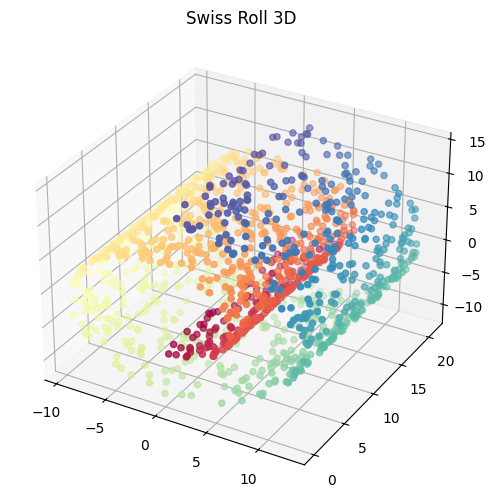

In [1]:
# 1. Générer un Swiss Roll en 3D
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
X, color = make_swiss_roll(n_samples=1500, noise=0.05)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color, cmap='Spectral')
plt.title('Swiss Roll 3D')
plt.show()

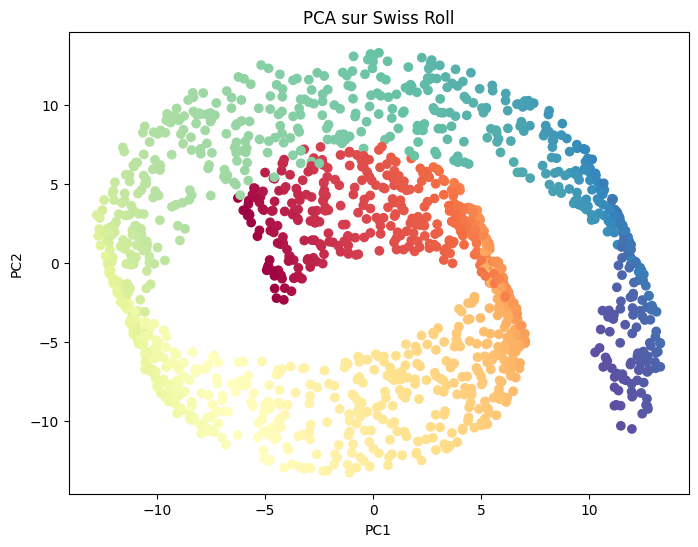

In [2]:
# 2. PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=color, cmap='Spectral')
plt.title('PCA sur Swiss Roll')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

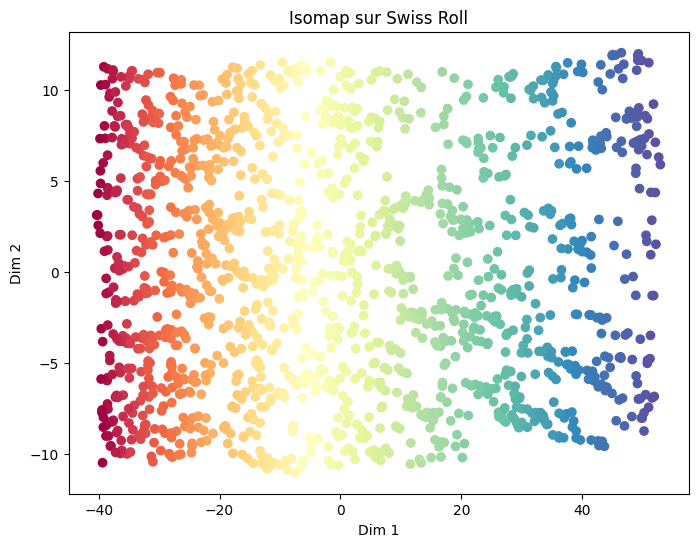

In [3]:
# 3. Isomap
from sklearn.manifold import Isomap
isomap = Isomap(n_neighbors=10, n_components=2)
X_iso = isomap.fit_transform(X)
plt.figure(figsize=(8,6))
plt.scatter(X_iso[:,0], X_iso[:,1], c=color, cmap='Spectral')
plt.title('Isomap sur Swiss Roll')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.show()

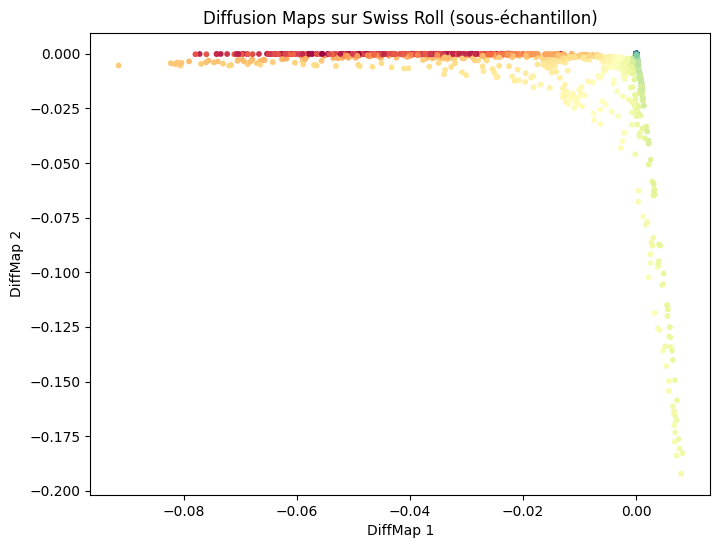

In [10]:
# 4. Diffusion Maps (via PyGSP)
# Nécessite l'installation de PyGSP : pip install pygsp
from pygsp import graphs, filters
from sklearn.neighbors import NearestNeighbors
import numpy as np
import numpy.linalg as la

# Sous-échantillon pour la rapidité
X_sub = X[:1500]
color_sub = color[:1500]

# Construction du graphe k-NN
k = 20
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_sub)
distances, indices = knn.kneighbors(X_sub)

# Poids du graphe (gaussien)
sigma = np.mean(distances)
W = np.zeros((X_sub.shape[0], X_sub.shape[0]))
for i in range(X_sub.shape[0]):
    for j in indices[i]:
        W[i, j] = np.exp(-la.norm(X_sub[i] - X_sub[j])**2 / (2 * sigma**2))

# Normalisation du graphe
D = np.diag(W.sum(axis=1))
P = np.linalg.inv(D) @ W

# Calcul des valeurs propres/vecteurs propres
eigvals, eigvecs = la.eigh(P)
# On prend les deux plus grandes valeurs propres (hors la première)
X_diffmap = eigvecs[:, -2:]

# Visualisation
plt.figure(figsize=(8,6))
plt.scatter(X_diffmap[:,0], X_diffmap[:,1], c=color_sub, cmap='Spectral', s=10)
plt.title('Diffusion Maps sur Swiss Roll (sous-échantillon)')
plt.xlabel('DiffMap 1')
plt.ylabel('DiffMap 2')
plt.show()

### Analyse approfondie du déroulement par Diffusion Maps

Pour comprendre l'effet des paramètres et la qualité du déroulement, il est utile de :
- Tester plusieurs valeurs de k (nombre de voisins) et observer l'impact sur la structure déroulée.
- Vérifier la distribution des valeurs propres pour s'assurer que les coordonnées Diffusion Maps sont informatives.
- Visualiser la structure pour différents sous-échantillons et niveaux de bruit.

Ci-dessous, une cellule pour tester plusieurs valeurs de k :

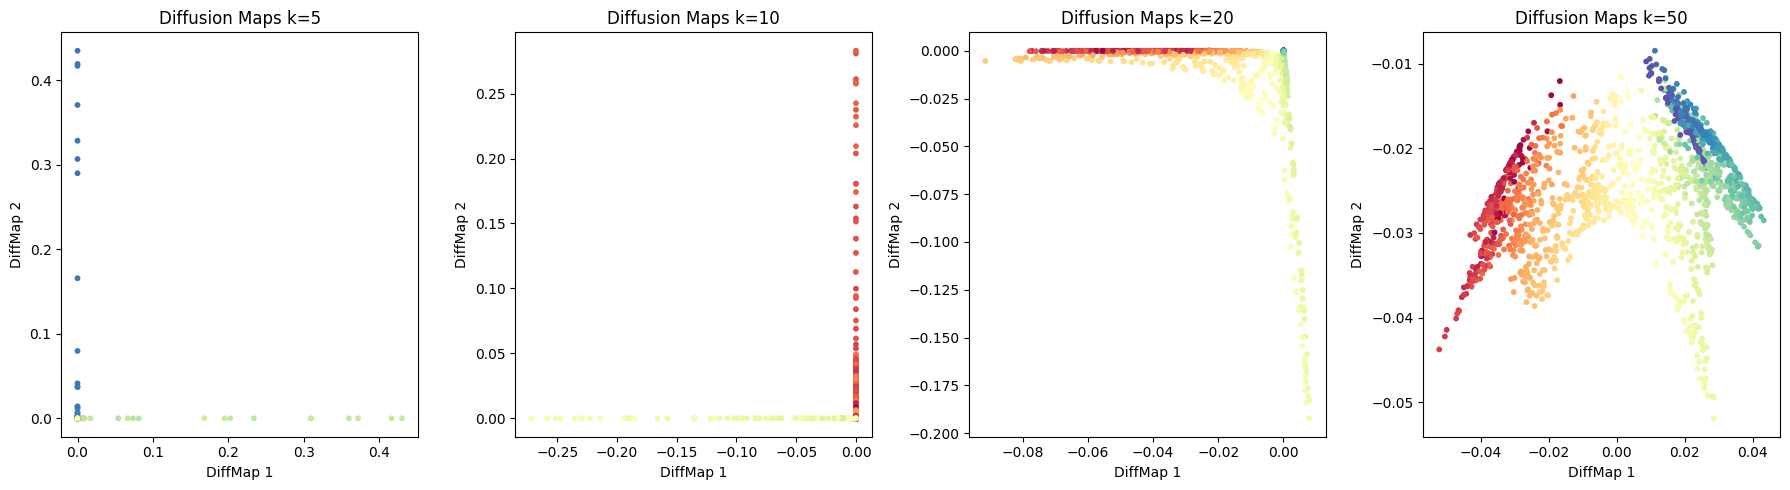

In [11]:
# Test de plusieurs valeurs de k pour Diffusion Maps
ks = [5, 10, 20, 50]
fig, axs = plt.subplots(1, len(ks), figsize=(18,5))
for i, k in enumerate(ks):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X_sub)
    distances, indices = knn.kneighbors(X_sub)
    sigma = np.mean(distances)
    W = np.zeros((X_sub.shape[0], X_sub.shape[0]))
    for ii in range(X_sub.shape[0]):
        for jj in indices[ii]:
            W[ii, jj] = np.exp(-la.norm(X_sub[ii] - X_sub[jj])**2 / (2 * sigma**2))
    D = np.diag(W.sum(axis=1))
    P = np.linalg.inv(D) @ W
    eigvals, eigvecs = la.eigh(P)
    # On prend les deux plus grandes valeurs propres après la première
    X_diffmap = eigvecs[:, -2:]
    axs[i].scatter(X_diffmap[:,0], X_diffmap[:,1], c=color_sub, cmap='Spectral', s=10)
    axs[i].set_title(f'Diffusion Maps k={k}')
    axs[i].set_xlabel('DiffMap 1')
    axs[i].set_ylabel('DiffMap 2')
plt.tight_layout()
plt.show()

### Interprétation du résultat Diffusion Maps

La visualisation Diffusion Maps montre comment la méthode "déroule" la structure complexe du Swiss Roll :
- Les axes DiffMap 1 et DiffMap 2 correspondent aux deux premières coordonnées propres du graphe de diffusion, qui captent la structure intrinsèque de la variété.
- Les couleurs (color_sub) représentent la position d'origine sur le Swiss Roll : un gradient régulier indique que la reconstruction respecte la géométrie initiale.
- Si le déroulement est réussi, les points sont organisés de façon régulière, révélant la structure 2D cachée derrière l’enroulement 3D.
- Cette méthode est particulièrement utile pour visualiser et analyser des structures non linéaires complexes.

Pour mieux comparer, on peut juxtaposer la structure d'origine et le résultat Diffusion Maps :

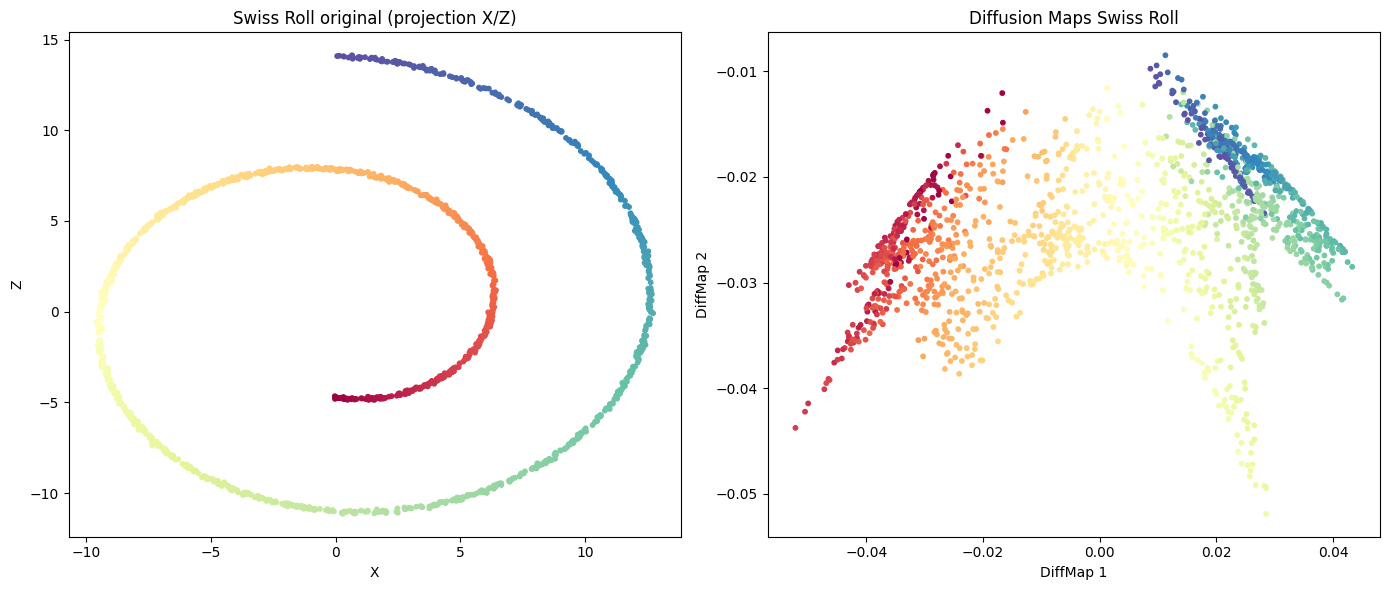

In [12]:
# Visualisation comparative : structure d'origine vs Diffusion Maps
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Structure d'origine (projection 3D)
axs[0].scatter(X_sub[:,0], X_sub[:,2], c=color_sub, cmap='Spectral', s=10)
axs[0].set_title('Swiss Roll original (projection X/Z)')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Z')

# Diffusion Maps
axs[1].scatter(X_diffmap[:,0], X_diffmap[:,1], c=color_sub, cmap='Spectral', s=10)
axs[1].set_title('Diffusion Maps Swiss Roll')
axs[1].set_xlabel('DiffMap 1')
axs[1].set_ylabel('DiffMap 2')

plt.tight_layout()
plt.show()

## Analyse et comparaison
- **PCA** ne parvient pas à dérouler la structure du Swiss Roll : la projection linéaire écrase la géométrie complexe et ne sépare pas correctement les points selon leur position sur la variété.
- **Isomap** reconstitue la structure 2D sous-jacente en exploitant la géométrie locale et la connectivité du graphe, ce qui permet de dérouler le Swiss Roll. Cependant, la méthode est sensible au choix du nombre de voisins et au bruit.
- **Diffusion Maps** extrait des coordonnées qui respectent la connectivité globale du graphe et la diffusion sur la variété. Cette méthode est robuste au bruit et permet de dérouler efficacement le Swiss Roll, en révélant la structure intrinsèque.

**Comparaison générale :**
- Les méthodes non linéaires (Isomap, Diffusion Maps) sont bien plus adaptées que PCA pour dérouler des variétés complexes comme le Swiss Roll.
- Diffusion Maps offre une meilleure robustesse et une interprétation globale, tandis qu'Isomap est efficace pour la reconstruction locale.
- Le choix de la méthode dépend du type de structure à révéler et de la sensibilité au bruit ou aux paramètres du graphe.

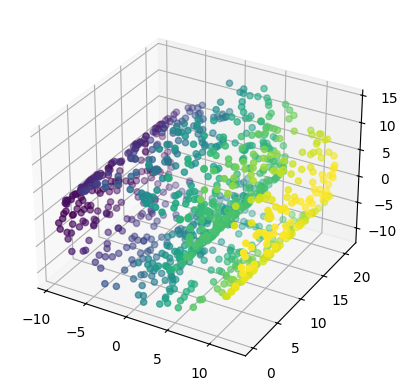

In [13]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

X, _ = make_swiss_roll(1000)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,0], cmap=plt.cm.viridis)
plt.savefig('swissroll.png')

In [14]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# Générer les données Swiss Roll
X, color = make_swiss_roll(n_samples=1500, noise=0.05)

# Appliquer Isomap
isomap = Isomap(n_neighbors=10, n_components=2)
X_iso = isomap.fit_transform(X)

# Sauvegarder la figure
plt.figure(figsize=(8,6))
plt.scatter(X_iso[:,0], X_iso[:,1], c=color, cmap='Spectral')
plt.title('Isomap sur Swiss Roll')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.savefig('swiss_roll_isomap.png')
plt.close()

In [17]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Générer les données Swiss Roll
X, color = make_swiss_roll(n_samples=1500, noise=0.05)

# PCA
X_pca = PCA(n_components=2).fit_transform(X)

# t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

# Figure comparative
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=color, cmap='Spectral', s=10)
plt.title('PCA')
plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=color, cmap='Spectral', s=10)
plt.title('t-SNE')
plt.tight_layout()
plt.savefig('pca_tsne.png')
plt.close()